In [ ]:
import numpy as np
import wfdb
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

# Load clean ECG data from the MIT-BIH Arrhythmia Database
def load_clean_ecg_data(data_path):
    records = [f.split('.')[0] for f in os.listdir(data_path) if f.endswith('.dat')]
    X, Y = [], []
    for record in records:
        signal, fields = wfdb.rdsamp(os.path.join(data_path, record))
        ann = wfdb.rdann(os.path.join(data_path, record), 'atr')
        for i in range(len(ann.sample)):
            if i == 0 or i == len(ann.sample) - 1:
                continue
            r_peak = ann.sample[i]
            start = r_peak - 100
            end = r_peak + 100
            if start < 0 or end > len(signal):
                continue
            heartbeat = signal[start:end, 0]
            X.append(heartbeat)
            Y.append(ann.symbol[i])
    return np.array(X), np.array(Y)

# Load noise data from the NSTDB
def load_noise_data(noise_path):
    noise_files = [f.split('.')[0] for f in os.listdir(noise_path) if f.endswith('.dat')]
    noise_signals = []
    for noise_file in noise_files:
        signal, fields = wfdb.rdsamp(os.path.join(noise_path, noise_file))
        noise_signals.append(signal[:, 0])
    return noise_signals

# Add noise to clean ECG signals with correct noise selection
def add_noise_to_ecg(ecg_signals, noise_signals, snr_db):
    noisy_ecg = []
    for ecg in ecg_signals:
        noise = noise_signals[np.random.randint(0, len(noise_signals))]
        if len(noise) > len(ecg):
            noise = noise[:len(ecg)]
        else:
            noise = np.pad(noise, (0, len(ecg) - len(noise)), 'wrap')
        rms_ecg = np.sqrt(np.mean(ecg**2))
        rms_noise = np.sqrt(np.mean(noise**2))
        desired_rms_noise = rms_ecg / (10**(snr_db / 20))
        noise = noise * (desired_rms_noise / rms_noise)
        noisy_ecg.append(ecg + noise)
    return np.array(noisy_ecg)

# Map labels to binary classes
def label_ecg(y):
    normal_classes = ['N', 'L', 'R']
    return 0 if y in normal_classes else 1

# Define Transformer model
def create_transformer_model(input_shape, num_heads=2, ff_dim=32):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same", activation="relu")(inputs)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    for _ in range(2):
        x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
        attention_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(x1, x1)
        x2 = tf.keras.layers.Add()([x, attention_output])
        x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        ffn_output = tf.keras.layers.Dense(ff_dim, activation="relu")(x3)
        ffn_output = tf.keras.layers.Dense(x.shape[-1])(ffn_output)
        x = tf.keras.layers.Add()([x2, ffn_output])
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Paths to the datasets
mitbih_path = "/content/physionet.org/files/mitdb/1.0.0"
nstdb_path = "/content/physionet.org/files/nstdb/1.0.0"

# Load and preprocess data
X_clean, Y_clean = load_clean_ecg_data(mitbih_path)
noise_signals = load_noise_data(nstdb_path)
X_noisy = add_noise_to_ecg(X_clean, noise_signals, snr_db=6)

# Normalize the data
scaler = StandardScaler()
X_noisy = np.array([scaler.fit_transform(x.reshape(-1, 1)).flatten() for x in X_noisy])

# Map labels
Y = np.array([label_ecg(y) for y in Y_clean])

# Train-test split
X_train, X_val, Y_train, Y_val = train_test_split(X_noisy, Y, test_size=0.2, random_state=42, stratify=Y)
X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, test_size=0.2, random_state=42, stratify=Y_val)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
X_val = X_val[..., np.newaxis]

# Create and train the Transformer model
model = create_transformer_model((X_train.shape[1], 1))

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y_train),
    y=Y_train
)
class_weight_dict = dict(enumerate(class_weights))

history = model.fit(X_train, Y_train, epochs=20, batch_size=32,
                    validation_data=(X_val, Y_val), class_weight=class_weight_dict)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f'Test Accuracy: {test_acc:.4f}')


Epoch 1/20
2814/2814 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - accuracy: 0.7713 - loss: 0.5096 - val_accuracy: 0.8214 - val_loss: 0.4543
Epoch 2/20
2814/2814 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.8901 - loss: 0.3541 - val_accuracy: 0.9163 - val_loss: 0.2630
Epoch 3/20
2814/2814 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9137 - loss: 0.3027 - val_accuracy: 0.9050 - val_loss: 0.2781
Epoch 4/20
2814/2814 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.9173 - loss: 0.2839 - val_accuracy: 0.9352 - val_loss: 0.2135
Epoch 5/20
2814/2814 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9249 - loss: 0.2567 - val_accuracy: 0.9299 - val_loss: 0.2489
Epoch 6/20
2814/2814 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9315 - loss: 0.2407 - val_accuracy: 0.9092 - val_loss: 0.2665
Epoch 7/20
2814/2814 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.9322 - loss: 0.2312 - val_accuracy: 0.9266 - val_loss: 0.2047
Epoch 8/20
2814/2814 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9362 - loss: 0

Model saved to updated_ecg_transformer_model.keras


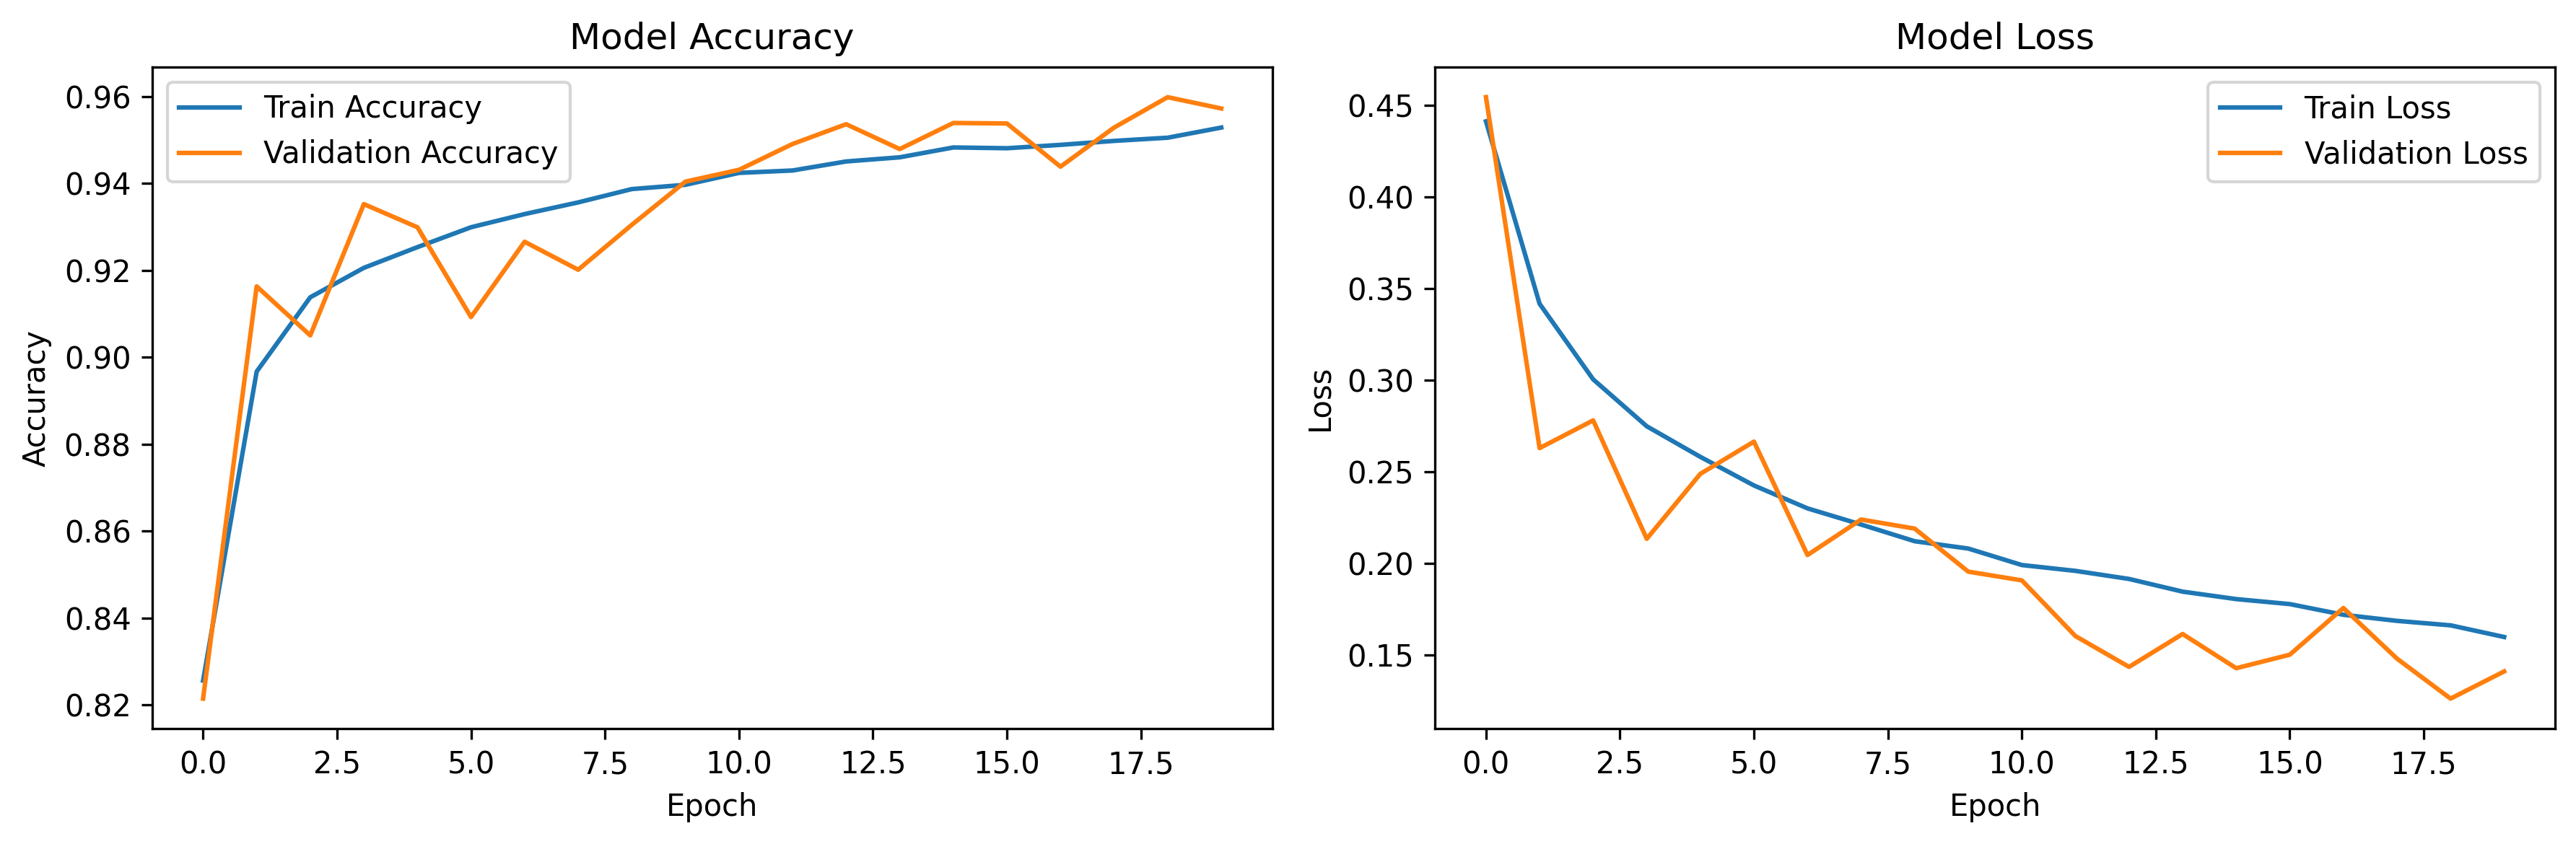

141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9596 - loss: 0.1489
Test Loss: 0.1531, Test Accuracy: 0.9558


In [ ]:
import matplotlib.pyplot as plt

# Save the trained model
model_save_path = 'updated_ecg_transformer_model.keras'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

# Plot training history
def plot_training_history(history):
    # Plot Accuracy
    plt.figure(figsize=(12, 4),dpi=300)

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # Set DPI to 300
    plt.tight_layout()
    plt.savefig('ECG_model.png', dpi=300)
    plt.show()

# Call the function to plot the results
plot_training_history(history)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')


In [ ]:
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions and metrics
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Classification report
print("\nClassification Report:")
print(classification_report(Y_test, y_pred))




141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      3614
           1       0.87      0.91      0.89       888

    accuracy                           0.96      4502
   macro avg       0.92      0.94      0.93      4502
weighted avg       0.96      0.96      0.96      4502



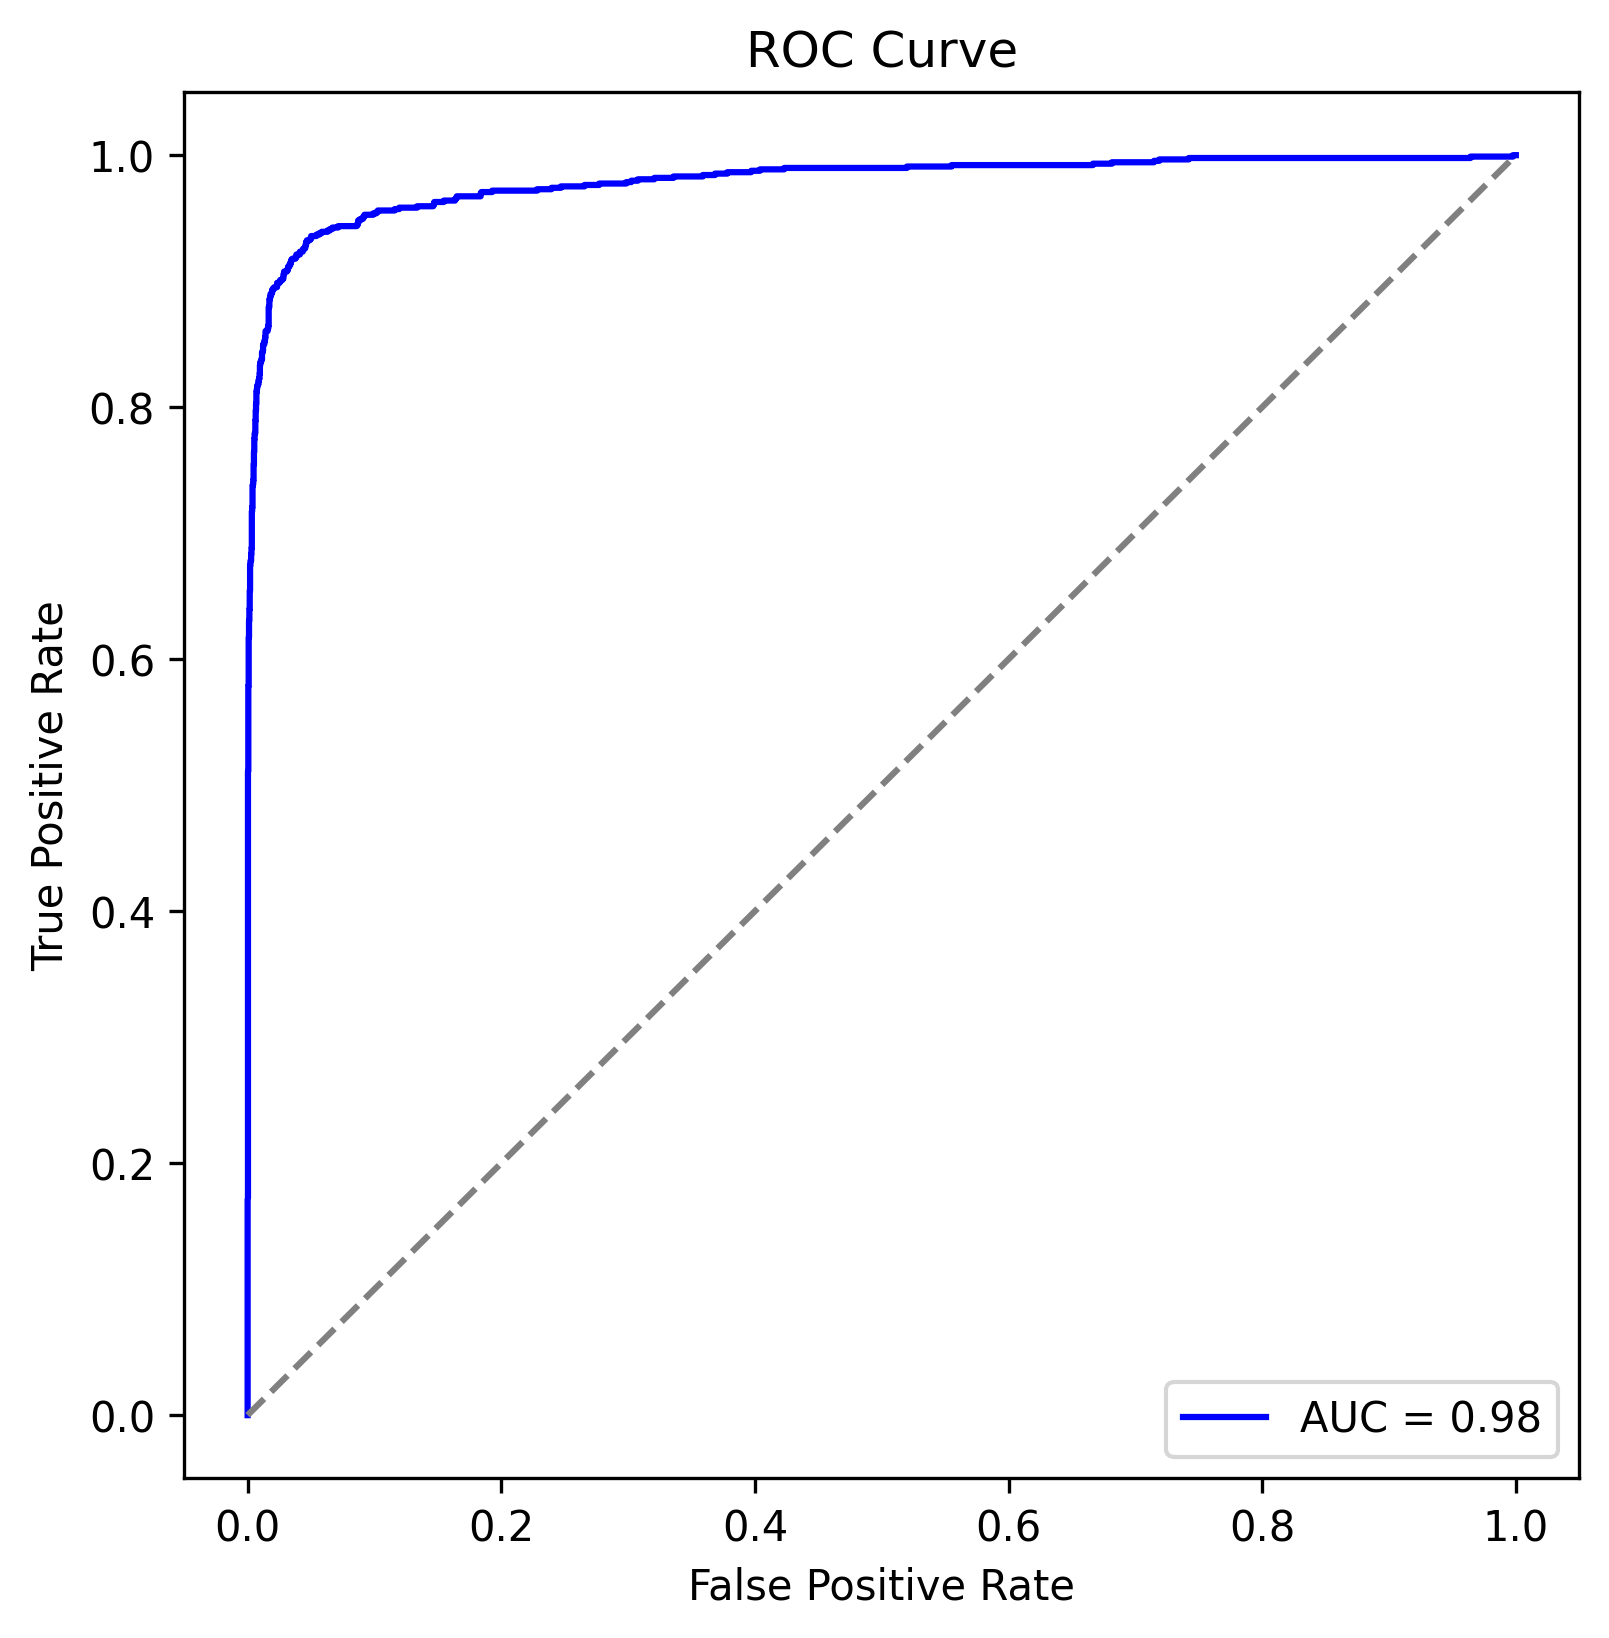

In [ ]:

# ROC Curve
fpr, tpr, _ = roc_curve(Y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 6), dpi=300)
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.savefig('roc_curve.png', dpi=300)
plt.show()


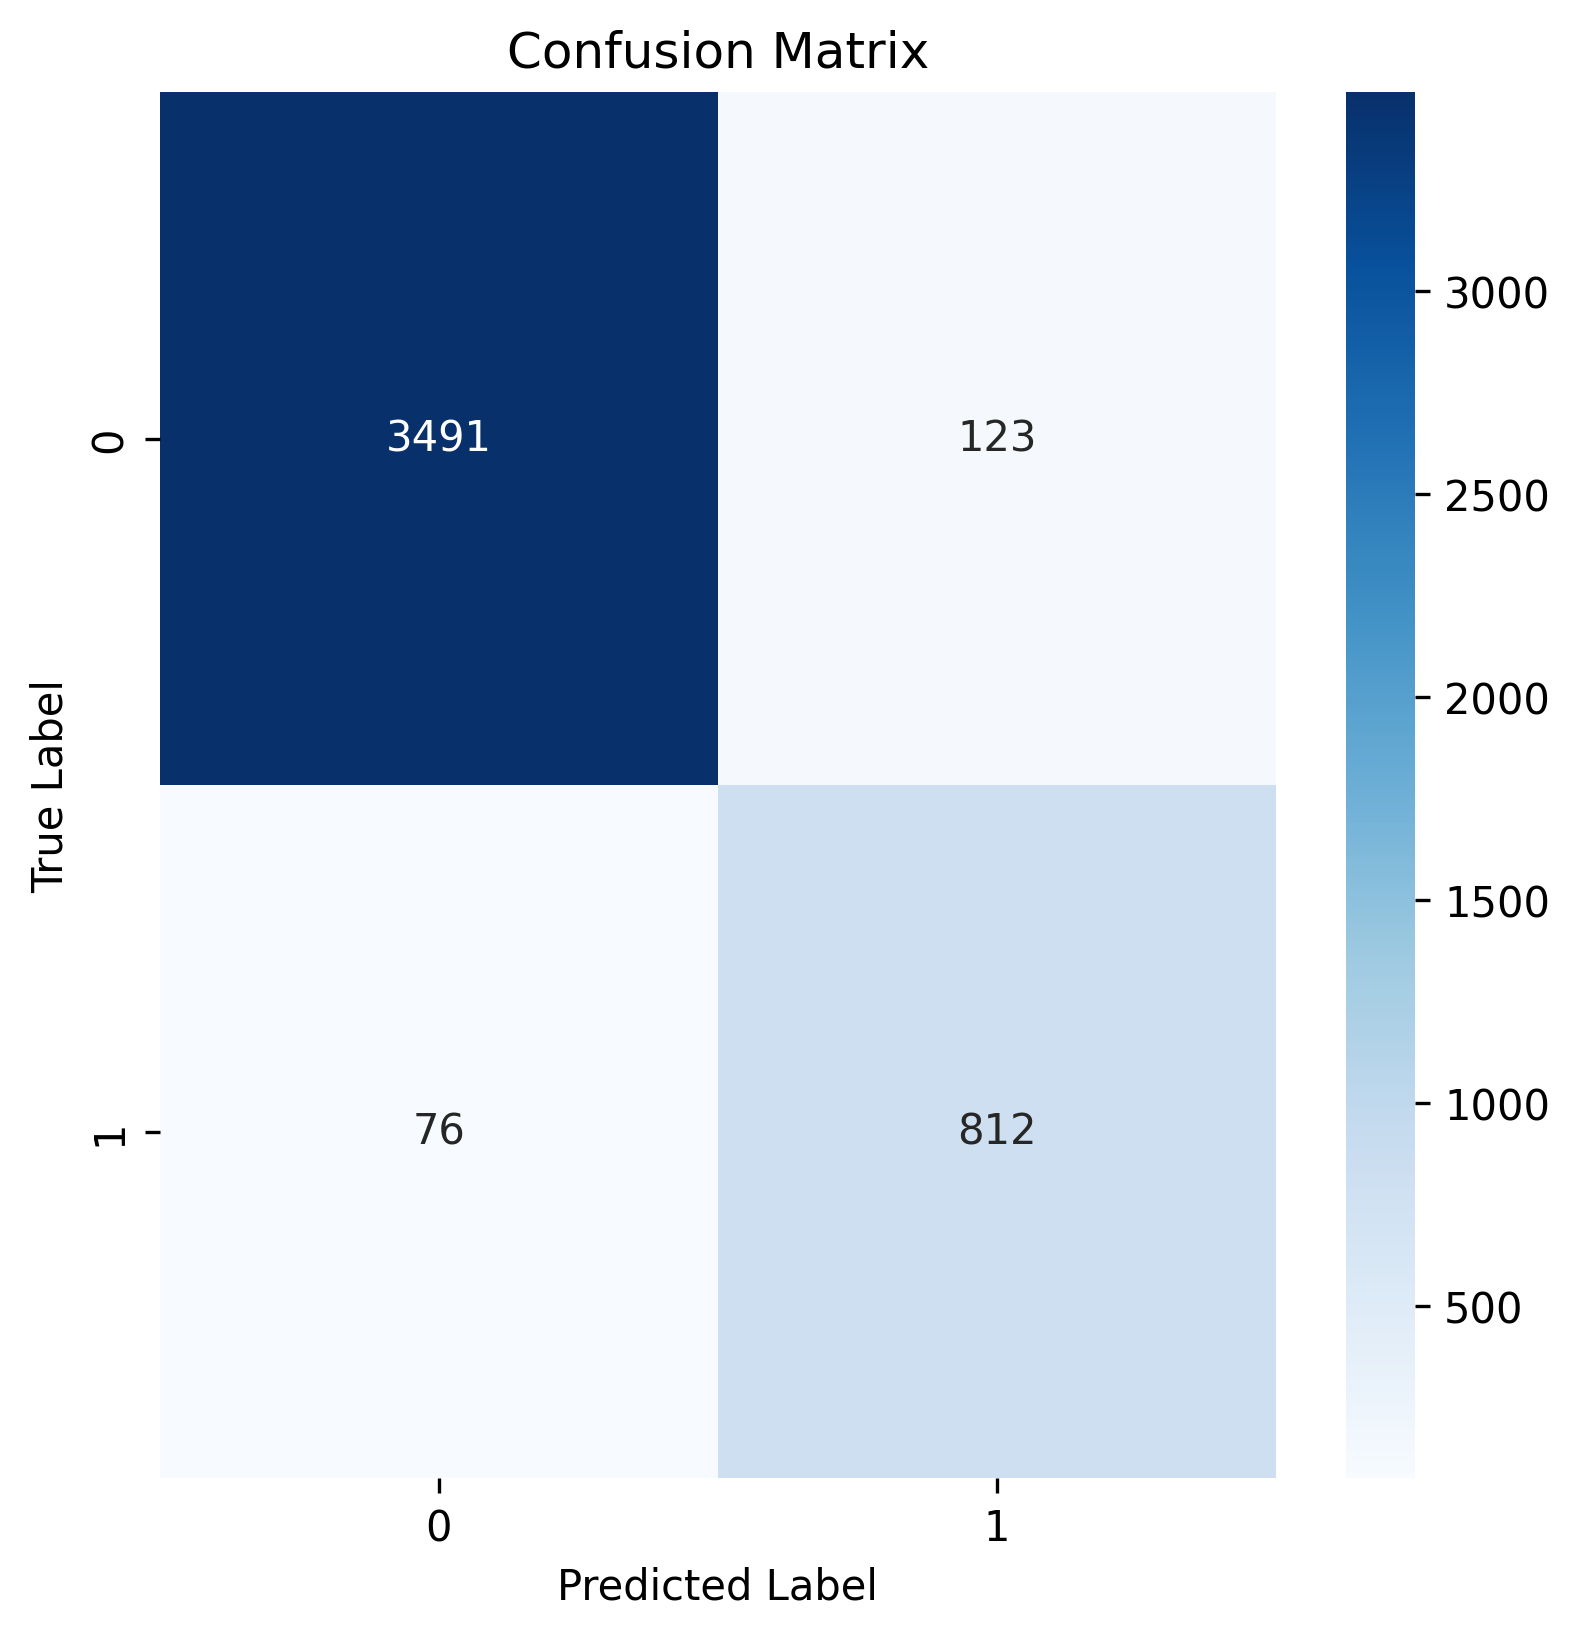

In [ ]:
# Confusion Matrix
cm = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(6, 6), dpi=300)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()
